In [1]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum Enhanced Optimization for Radar and Communications Applications 


The Low Autocorrelation Binary Sequences (LABS) is an important and challenging optimization problem with applications related to radar, telecommunications, and other signal related applications. This CUDA-Q Academic module will focus on a clever quantum-enhanced hybrid method developed in a collaboration between Kipu Quantum, University of the Basque Country EHU, and NVIDIA for solving the LABS problem. (This notebook was jointly developed with input from all collaborators.)

Other CUDA-Q Academic modules like [Divide and Conquer MaxCut QAOA](https://github.com/NVIDIA/cuda-q-academic/tree/main/qaoa-for-max-cut) and [Quantum Finance](https://github.com/NVIDIA/cuda-q-academic/blob/main/quantum-applications-to-finance/03_qchop.ipynb), demonstrate how quantum computing can be used outright to solve optimization problems. This notebook demonstrates a slightly different approach. Rather than considering QPUs as the tool to produce the final answer, it demonstrates how quantum can be used to enhance the effectiveness of leading classical methods.  

The benefits of such an approach were highlighted in [Scaling advantage with quantum-enhanced memetic tabu search for LABS](https://arxiv.org/html/2511.04553v1).  This notebook, co-created with the authors of the paper, will allow you to explore the findings of their research and write your own CUDA-Q code that builds a representative quantum-enhanced workflow for solving the LABS problem. Moreover, it will introduce advancements in counteradiabatic optimization techniques on which reduce the quantum resources required to run on a QPU.

**Prerequisites:** This lab assumes you have a basic knowledge of quantum computing, including operators, gates, etc.  For a refresher on some of these topics, explore the [Quick start to Quantum](https://github.com/NVIDIA/cuda-q-academic/tree/main/quick-start-to-quantum) series.

**In this lab you will:**
* 1. Understand the LABS problem and its relation ot radar and communication applications.
* 2. Solve LABS classically with memetic tabu search and learn about the limitations of such methods.
* 3. Code a couteradiabatic algorithm using CUDA-Q to produce approximate solutions to the LABS problem.
* 4. Use the CUDA-Q results to seed your tabu search and understand the potential benefits of this approach.


**Terminology you will use:**
* Low autocorrelation of binary sequences (LABS)
* counteradiabatic optimization
* memetic-tabu search

**CUDA-Q Syntax you will use:**
* cudaq.sample()
* @cudaq.kernel
* ry(), rx(), rz(), x(), h() 
* x.ctrl()

Run the code below to initialize the libraries you will need.

In [1]:
import cudaq
import numpy as np
from math import floor
import auxiliary_files.labs_utils as utils

# Configure CUDA-Q to use GPU
cudaq.set_target('nvidia')  # Use NVIDIA GPU backend
print(f"Using CUDA-Q target: {cudaq.get_target().name}")

## The LABS problem and applications

The **Low Autocorrelation Binary Sequences (LABS)** problem is fundamental to many applications, but originated with applications to radar. 

Consider a radar that monitors airport traffic.  The radar signal sent to detect incoming planes must have as much range as possible to ensure safe approaches are planned well in advance.  The range of a radar signal can be increased by sending a longer pulse.  However, in order to differentiate between multiple objects, pulses need to be short to provide high resolution. So, how do you handle situations where you need both?

One solution is a technique called pulse compression.  The idea is to send a long signal, but vary the phase at regular intervals such that the resolution is increased. Generally, the initial signal will encode a binary sequence of phase shifts, where each interval corresponds to a signal with a 0 or 180 degree phase shift. 

The tricky part is selecting an optimal encoding sequence.  When the signal returns, it is fed into a matched filter with the hope that a singular sharp peak will appear, indicating clear detection.  The autocorrelation of the original signal, or how similar the signal is to itself,  determines if a single peak or a messier signal with sidelobes will be detected. A signal should have high autocorrelation when overlayed on top of itself, but low autocorrelation when shifted with a lag. 

Consider the image below.  The signal on the left has a crisp single peak while the single on the right produces many undesirable sidelobes which can inhibit clear detection.  

<img src="images/quantum_enhanced_optimization_LABS/radar.png" width="800">


So, how do you select a good signal?   This is where LABS comes in, defining these questions as a binary optimization problem. Given a binary sequence of length $N$, $(s_1 \cdots s_N) \in {\pm 1}^N$, the goal is to minimize the following objective function.

$$ E(s) = \sum_{k=1}^{N-1} C_k^2 $$

Where $C_k$ is defined as. 

 $$C_k= \sum_{i=1}^{N-k} s_is_{i+k}$$


So, each $C_k$ computes how similar the original signal is to the shifted one for each offset value $k$.  To explore this more, try the interactive widget linked [here](https://nvidia.github.io/cuda-q-academic/interactive_widgets/labs_visualization.html).  See if you can select a very good and very poor sequence and see the difference for the case of $N=7$.

## Classical Solution of the LABS problem

The LABS problem is tricky to solve for a few reasons. First, the configuration space grows exponentially.  Second, underlying symmetries of the problem result in many degeneracies in the optimization landscape severely inhibiting local search methods. 

<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 1:</h3>
    <p style="font-size: 16px; color: #333;">
Using the widget above, try to find some of the symmetries for the LABS problem. That is, for a fixed bitstring length, can you find patterns to produce the same energy with different pulse patterns. 
</div>

The best known performance for a classical optimization technique is Memetic Tabu search (MTS) which exhibits a scaling of $O(1.34^N)$.  The MTS algorithm is depicted below.  It begins with a randomly selected population of bitstrings and finds the best solution from them.  Then, a child is selected by sampling directly from or combining multiple bitstrings from the population.  The child is mutated with probability $p_{mutate}$ and then input to a tabu search, which performs a modified greedy local search starting from the child bitstring.  If the result is better than the best in the population, it is updated as the new leader and randomly replaces a  bitstring in the population.


<img src="images/quantum_enhanced_optimization_LABS/mts_algorithm.png" width="500">

Such an approach is fast, parallelizable, and allows for exploration with improved searching of the solution landscape.  

<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 2:</h3>
    <p style="font-size: 16px; color: #333;">
Before exploring any quantum approach, get a sense for how MTS works by coding it yourself based generally on the figure above. Algorithms for the combine and mutate steps are provided below as used in the paper. You may need to research more specific details of the process, especially for how tabu search is performed. The MTS procedure should output and optimal bitstring and its energy.  Also, write a function to visualize the results including the energy distribution of the final population.
</div>



<img src="images/quantum_enhanced_optimization_LABS/combine_mutate.png" width="400">



In [ ]:
# #TODO - Write code to perform MTSimport numpy as np
# import copy
# import random
# import matplotlib.pyplot as plt

# # --- 1. Define the Energy Function ---
# def calculate_energy(sequence):
#     """
#     Calculates the LABS energy (E) for a given binary sequence.
#     E(s) = sum_{k=1}^{N-1} (C_k)^2
#     where C_k = sum_{i=1}^{N-k} s_i * s_{i+k}
#     """
#     N = len(sequence)
#     energy = 0
#     # Convert to numpy for faster slicing if not already
#     s = np.array(sequence)
    
#     for k in range(1, N):
#         # Autocorrelation at lag k
#         # s[:N-k] corresponds to s_i (from i=1 to N-k)
#         # s[k:] corresponds to s_{i+k}
#         C_k = np.dot(s[:N-k], s[k:])
#         energy += C_k**2
        
#     return energy

# # --- 2. Define Tabu Search (Local Search) ---
# def tabu_search(initial_sequence, max_iter=100, tabu_tenure=5):
#     """
#     Performs a local Tabu search starting from initial_sequence.
#     """
#     current_seq = np.array(initial_sequence).copy()
#     best_seq = current_seq.copy()
#     current_energy = calculate_energy(current_seq)
#     best_energy = current_energy
    
#     N = len(current_seq)
#     tabu_list = [] # Queue of indices that are tabu
    
#     for _ in range(max_iter):
#         best_neighbor = None
#         best_neighbor_energy = float('inf')
#         move_index = -1
        
#         # Evaluate all 1-flip neighbors
#         for i in range(N):
#             if i in tabu_list:
#                 continue
                
#             # Flip bit i
#             neighbor = current_seq.copy()
#             neighbor[i] *= -1
#             e = calculate_energy(neighbor)
            
#             # Aspiration criterion: if it's better than global best, ignore tabu
#             if e < best_neighbor_energy:
#                 best_neighbor_energy = e
#                 best_neighbor = neighbor
#                 move_index = i
        
#         # If no valid move (shouldn't happen unless all tabu), break
#         if best_neighbor is None:
#             break
            
#         # Update current
#         current_seq = best_neighbor
#         current_energy = best_neighbor_energy
        
#         # Update Global Best
#         if current_energy < best_energy:
#             best_energy = current_energy
#             best_seq = current_seq.copy()
            
#         # Update Tabu List
#         tabu_list.append(move_index)
#         if len(tabu_list) > tabu_tenure:
#             tabu_list.pop(0)
            
#     return best_seq, best_energy

# # --- 3. Memetic Algorithm ---
# def mts(N, population_size=20, generations=10, p_mutate=0.2, initial_population=None):
#     """
#     Memetic Tabu Search.
#     """
#     # Initialize Population
#     if initial_population is None:
#         population = [np.random.choice([-1, 1], size=N) for _ in range(population_size)]
#     else:
#         population = initial_population
        
#     # Evaluate
#     energies = [calculate_energy(ind) for ind in population]
    
#     # Sort
#     sorted_indices = np.argsort(energies)
#     population = [population[i] for i in sorted_indices]
#     energies = [energies[i] for i in sorted_indices]
    
#     best_solution = population[0]
#     best_energy = energies[0]
    
#     history_best = []

#     for gen in range(generations):
#         # 1. Select Parent (Elite)
#         parent = population[0] 
        
#         # 2. Mutate (Simple bit flip mutation)
#         child = parent.copy()
#         if np.random.rand() < p_mutate:
#             idx = np.random.randint(0, N)
#             child[idx] *= -1
            
#         # 3. Local Search (Tabu)
#         refined_child, refined_energy = tabu_search(child, max_iter=50, tabu_tenure=N//4)
        
#         # 4. Replacement (Weakest replacement)
#         if refined_energy < energies[-1]:
#             population[-1] = refined_child
#             energies[-1] = refined_energy
            
#             # Re-sort
#             sorted_indices = np.argsort(energies)
#             population = [population[i] for i in sorted_indices]
#             energies = [energies[i] for i in sorted_indices]
            
#             if energies[0] < best_energy:
#                 best_energy = energies[0]
#                 best_solution = population[0]
                
#         history_best.append(best_energy)
        
#     return best_solution, best_energy, population, history_best

# # --- Test Run ---
# N_test = 13
# best_sol, best_en, final_pop, hist = mts(N_test, generations=20)
# print(f"MTS Result for N={N_test}: Energy = {best_en}")



MTS Result for N=13: Energy = 14


Generation 0: New best energy = 14
Generation 22: New best energy = 6

MTS Complete: Best energy = 6

Best sequence found: [ 1 -1  1 -1  1  1 -1 -1  1  1  1  1  1]
Best energy: 6


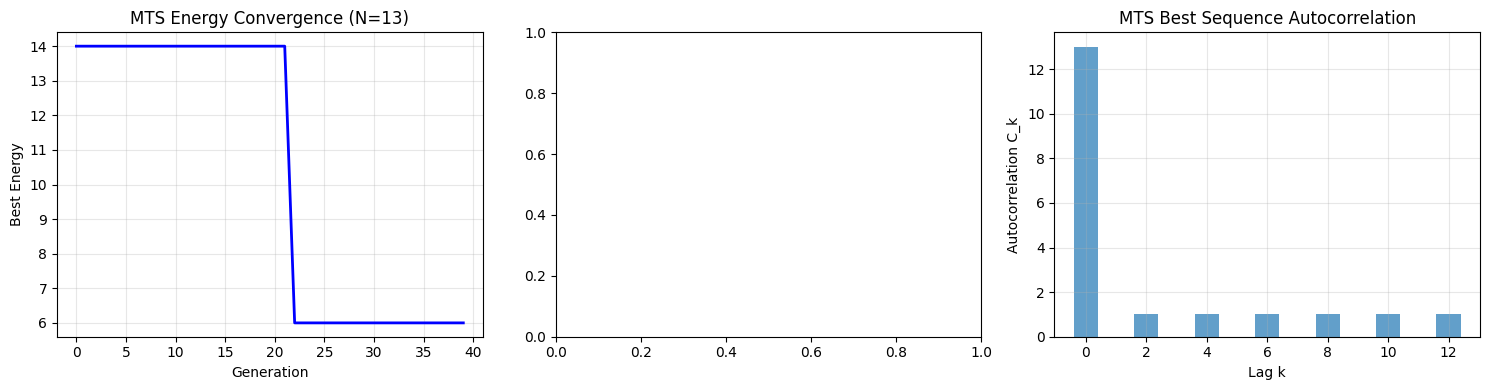

In [17]:

import numpy as np
import random
import matplotlib.pyplot as plt

# LABS Energy Computation
def compute_energy(sequence):

    s = np.array(sequence)
    N = len(s)
    energy = 0
    for k in range(1, N):
        C_k = np.dot(s[:N-k], s[k:])
        energy += C_k ** 2
    return energy

def compute_autocorrelation(sequence):
    """Compute all autocorrelation values C_k for visualization."""
    s = np.array(sequence)
    N = len(s)
    C = []
    for k in range(N):
        C_k = np.dot(s[:N-k], s[k:]) if k < N else 0
        C.append(C_k)
    return C

# Combine Operation (Single-point crossover)
def combine(p1, p2):
    
    N = len(p1)
    k = random.randint(1, N - 1)  # Cut point (1-based becomes 0-based slice)
    child = np.concatenate([p1[:k], p2[k:]])
    return child

# Mutate Operation (Flip each bit with probability p_mut)
def mutate(s, p_mut):
   
    child = s.copy()
    for i in range(len(child)):
        if random.random() < p_mut:
            child[i] *= -1  # Flip the bit
    return child

# Tabu Search (Local Search)
def tabu_search(initial_seq, max_iter=100, tabu_tenure=5):
       
    current = np.array(initial_seq).copy()
    best = current.copy()
    current_energy = compute_energy(current)
    best_energy = current_energy
    
    N = len(current)
    tabu_list = []
    
    for _ in range(max_iter):
        best_neighbor = None
        best_neighbor_energy = float('inf')
        best_move = -1
        
        # Evaluate all 1-flip neighbors
        for i in range(N):
            neighbor = current.copy()
            neighbor[i] *= -1
            e = compute_energy(neighbor)
            
            is_tabu = i in tabu_list
            beats_best = e < best_energy  
            
            # Accept if not tabu OR if it beats global best 
            if (not is_tabu) or beats_best:
                if e < best_neighbor_energy:
                    best_neighbor_energy = e
                    best_neighbor = neighbor
                    best_move = i
        
        if best_neighbor is None:
            break
            
        current = best_neighbor
        current_energy = best_neighbor_energy
        
        # Update global best
        if current_energy < best_energy:
            best_energy = current_energy
            best = current.copy()
        
        # Update tabu list (FIFO queue)
        tabu_list.append(best_move)
        if len(tabu_list) > tabu_tenure:
            tabu_list.pop(0)
            
    return best, best_energy

# Population Initialization
def initialize_population_random(N, pop_size):
    return [np.random.choice([-1, 1], size=N) for _ in range(pop_size)]

def initialize_population_from_samples(samples, pop_size, N):
    population = []
    for sample in samples[:pop_size]:
        if isinstance(sample, str):
            # Convert bitstring to +1/-1 (0 -> +1, 1 -> -1)
            seq = np.array([1 if b == '0' else -1 for b in sample])
        else:
            seq = np.array(sample)
        population.append(seq)
    
    # If not enough samples, add random sequences
    while len(population) < pop_size:
        seq = np.random.choice([-1, 1], size=N)
        population.append(seq)
    
    return population

# Memetic Tabu Search (MTS) 
def memetic_tabu_search(N, pop_size=20, generations=50, p_mut=0.1, E_target=0,
                        tabu_iterations=50, tabu_tenure=None,
                        initial_population=None, verbose=True):

    
    if tabu_tenure is None:
        tabu_tenure = max(N // 4, 3)
    
    # Initialize population with k random bitstrings
    if initial_population is None:
        population = initialize_population_random(N, pop_size)
    else:
        population = [np.array(p) for p in initial_population]
    
    # Compute initial energies
    energies = [compute_energy(ind) for ind in population]
    
    # s_star = best solution in population
    best_idx = np.argmin(energies)
    s_star = population[best_idx].copy()
    E_star = energies[best_idx]
    
    history = []
    
    # Main loop: while E(s_star) > E_target
    for gen in range(generations):
        if E_star <= E_target:
            if verbose:
                print(f"Target energy {E_target} reached at generation {gen}!")
            break
        
        #  MakeChild - two options
        if random.random() < 0.5:
            # Sample a bitstring directly from population
            child = random.choice(population).copy()
        else:
            # Combine two parent bitstrings from population
            idx1, idx2 = random.sample(range(pop_size), 2)
            child = combine(population[idx1], population[idx2])
        
        #  Mutate child
        child = mutate(child, p_mut)
        
        # Tabu Search on child
        child_result, child_energy = tabu_search(
            child, max_iter=tabu_iterations, tabu_tenure=tabu_tenure
        )
        
        # Update best solution (s_star)
        if child_energy < E_star:
            E_star = child_energy
            s_star = child_result.copy()
            if verbose:
                print(f"Generation {gen}: New best energy = {E_star}")
        
        #  Update population - replace RANDOM member if child is better
        random_idx = random.randint(0, pop_size - 1)
        if child_energy < energies[random_idx]:
            population[random_idx] = child_result
            energies[random_idx] = child_energy
        
        history.append(E_star)
    
    if verbose:
        print(f"\nMTS Complete: Best energy = {E_star}")
    
    return s_star, E_star, population, history

# Visualization Functions
def visualize_mts_results(history, population, N, title_prefix=""):
    """Visualize MTS optimization results."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Plot 1: Energy convergence
    ax1 = axes[0]
    ax1.plot(range(len(history)), history, 'b-', linewidth=2)
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Best Energy')
    ax1.set_title(f'{title_prefix}Energy Convergence (N={N})')
    ax1.grid(True, alpha=0.3)
    
    final_energies = [compute_energy(seq) for seq in population]
   
    
    # Plot 2: Best sequence autocorrelation
    ax3 = axes[2]
    best_idx = np.argmin(final_energies)
    best_seq = population[best_idx]
    autocorr = compute_autocorrelation(best_seq)
    ax3.bar(range(len(autocorr)), autocorr, alpha=0.7)
    ax3.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    ax3.set_xlabel('Lag k')
    ax3.set_ylabel('Autocorrelation C_k')
    ax3.set_title(f'{title_prefix}Best Sequence Autocorrelation')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    


# Run MTS on N=13 (known optimal E=4)
N_demo = 13
best_seq, best_energy, final_pop, history = memetic_tabu_search(
    N=N_demo,
    pop_size=15,
    generations=40,
    p_mut=0.1,
    tabu_iterations=50,
    verbose=True
)

print(f"\nBest sequence found: {best_seq}")
print(f"Best energy: {best_energy}")

# Visualize results
visualize_mts_results(history, final_pop, N_demo, title_prefix="MTS ")

## Building a Quantum Enhanced Workflow

Despite the effectiveness of MTS, it still exhibits exponential scaling  $O(1.34^N)$ behavior and becomes intractable for large $N$.  Quantum computing provides a potential alternative method for solving the LABS problem because the properties of entanglement, interference, and superpositon may allow for a better global search.  Recent demonstrations have even produced evidence that the quantum approximate optimization algorithm (QAOA) can be used to reduce the scaling of the LABS problem to $O(1.21^N)$ for $N$ between 28 and 40 with quantum minimum finding.

However, current quantum hardware limitations restrict solution to problems of greater than about $N=20$, meaning that it will be some time before quantum approaches can outperform the classical state of the art. It should also be noted that standard QAOA can struggle with LABS and require many layers to converge the parameters if other tricks are not employed.

The authors of [Scaling advantage with quantum-enhanced memetic tabu search for LABS](https://arxiv.org/html/2511.04553v1) cleverly explored an alternate path that combines quantum and classical approaches and might be able to provide a more near-term benefit.  Instead of expecting the quantum computer to solve the problem entirely, they asked how a quantum approach might enhance MTS.

The basic idea is that a quantum optimization routine could run first and the resulting state be sampled to produce a better population for MTS. Many such heuristics for defining the initial population are possible, but the rest of this notebook will explore their methodology, help you to build the workflow yourself, and allow you to analyze the benefits of their approach.

The first step of quantum enhanced MTS (QE-MTS) is to prepare a circuit with CUDA-Q that approximates the ground state of the Hamiltonian corresponding to the LABS problem. You could do this with any optimization algorithm such as QAOA or using an adiabatic approach.  (See the [Quantum Portfolio Optimization](https://github.com/NVIDIA/cuda-q-academic/blob/main/quantum-applications-to-finance/03_qchop.ipynb) CUDA-Q Academic lab for a detailed comparison of these two common approaches.)

The authors of this work opted for an adiabatic approach (More on why later). Recall that the goal of an adiabatic optimization is to begin with a Hamiltonian that has an easily prepared ground state ($H_i$). Then, the adiabatic Hamiltonian $H_{ad}$ can be constructed as $H_{ad}(\lambda) = (1-\lambda)H_i +\lambda H_f $, where $\lambda$ is a function of time and $H_f$ is the Hamiltonian representing a qubit encoding of the LABS problem. 

$$H_f = 2 \sum_{i=1}^{N-2} \sigma_i^z \sum_{k=1}^{\lfloor \frac{N-i}{2} \rfloor} \sigma_{i+k}^z 
+ 4 \sum_{i=1}^{N-3} \sigma_i^z \sum_{t=1}^{\lfloor \frac{N-i-1}{2} \rfloor} \sum_{k=t+1}^{N-i-t} \sigma_{i+t}^z \sigma_{i+k}^z \sigma_{i+k+t}^z$$

The authors also selected $H_i = \sum_i h^x_i \sigma^x_i $ which has an easily prepared ground state of $\ket{+}^{\otimes N}$.

The challenge for implementing the optimization procedure becomes selection of an operator that will quickly and accurately evolve to the ground state of $H_f$.  One approach is to use a so-called auxiliary countradiabatic (CD) term $H_{CD}$, which corrects diabatic transitions that jump out of the ground state during the evolution. The figure below demonstrates the benefit of using a CD correction.


<img src="images/quantum_enhanced_optimization_LABS/counteradiabatic.png" width="900">




An operator called the adiabatic gauge potential $A_{\lambda}$ is the ideal choice for the CD term as it suppresses all possible diabatic transitions, resulting in the following total system to evolve.

$$ H(\lambda) = H_{ad}(\lambda) + \lambda H_{CD} (\lambda) $$

$A(\lambda)$ is derrived from $H_{ad}(\lambda)$  (see paper for details) as it contains information about underlying physics of the problem. 

There is a problem though.  The $A(\lambda)$ term cannot be efficiently expressed exactly and needs to be approximated.  It also turns out that in the so called impulse regime, where the adiabatic evolution is very fast, $H_{cd} (\lambda)$ dominates $H_{ad}(\lambda)$, meaning that the final implementation corresponds to the operator $H(\lambda) = H^1_{cd}(\lambda)$ where  $H^1_{cd}(\lambda)$ is a first order approximation of $A(\lambda)$ (see equation 7 in the paper).

A final step is to use Trotterization to define the quantum circuit to apply $e^{-\theta (t) i H_{cd}}$. The details for this derivation are shown in the appendix of the paper. and result from equation B3 is shown below.  

$$
\begin{equation}
\begin{aligned}
U(0, T) = \prod_{n=1}^{n_{\text{trot}}} & \left[ \prod_{i=1}^{N-2} \prod_{k=1}^{\lfloor \frac{N-i}{2} \rfloor} R_{Y_i Z_{i+k}}\big(4\theta(n\Delta t)h_i^x\big) R_{Z_i Y_{i+k}}\big(4\theta(n\Delta t)h_{i+k}^x\big) \right] \\
& \times \prod_{i=1}^{N-3} \prod_{t=1}^{\lfloor \frac{N-i-1}{2} \rfloor} \prod_{k=t+1}^{N-i-t} \bigg( R_{Y_i Z_{i+t} Z_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_i^x\big) \\
& \quad \times R_{Z_i Y_{i+t} Z_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_{i+t}^x\big) \\
& \quad \times R_{Z_i Z_{i+t} Y_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_{i+k}^x\big) \\
& \quad \times R_{Z_i Z_{i+t} Z_{i+k} Y_{i+k+t}}\big(8\theta(n\Delta t)h_{i+k+t}^x\big) \bigg)
\end{aligned}
\end{equation}
$$

It turns out that this implementation is more efficient than QAOA in terms of gate count. The authors calculated that for $N=67$, QAOA would require 1.4 million entangling gates while the CD approach derived here requires only 236 thousand entangling gates.


<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 3:</h3>
    <p style="font-size: 16px; color: #333;">
At first glance, this equation might looks quite complicated. However, observe the structure and note two "blocks" of terms.  Can you spot them?  

They are 2 qubit terms that look like $R_{YZ}(\theta)$ or $R_{ZY}(\theta)$.

As well as 4 qubit terms that look like $R_{YZZZ}(\theta)$, $R_{ZYZZ}(\theta)$, $R_{ZZYZ}(\theta)$, or $R_{ZZZY}(\theta)$.

Thankfully the authors derive a pair of circuit implementations for the two and four qubit terms respectively, shown in the figures below.

Using CUDA-Q, write a kernel for each which will be used later to construct the full implementation.

* Hint: Remember that the adjoint of a rotation gate is the same as rotating in the opposite direction. 

* Hint: You may also want to define a CUDA-Q kernel for an R$_{ZZ}$ gate.

* Hint: Implementing a circuit from a paper is a great place where AI can help accelerate your work.  If you have access to a coding assistant, feel free to use it here.
</div>

<img src="images/quantum_enhanced_optimization_LABS/kernels.png" width="1300">


In [3]:
# --- Helper 1: The standard ZZ interaction ---
# exp(-i * theta/2 * Z_0 * Z_1)
@cudaq.kernel
def rzz(theta: float, q0: cudaq.qubit, q1: cudaq.qubit):
    x.ctrl(q0, q1)
    rz(theta, q1)
    x.ctrl(q0, q1)

# --- Helper 2: The standard ZZZZ interaction ---
# exp(-i * theta/2 * Z_0 * Z_1 * Z_2 * Z_3)
@cudaq.kernel
def rzzzz(theta: float, q0: cudaq.qubit, q1: cudaq.qubit, q2: cudaq.qubit, q3: cudaq.qubit):
    x.ctrl(q0, q1)
    x.ctrl(q1, q2)
    x.ctrl(q2, q3)
    rz(theta, q3)
    x.ctrl(q2, q3)
    x.ctrl(q1, q2)
    x.ctrl(q0, q1)

# --- Kernel 1: Two-Body YZ term ---
# Applies exp(-i * theta/2 * Y_i * Z_k)
@cudaq.kernel
def apply_ryz(theta: float, qi: cudaq.qubit, qk: cudaq.qubit):
    # 1. Rotate Basis: Y -> Z on qubit i
    rx(np.pi/2, qi)
    
    # 2. Apply ZZ interaction
    rzz(theta, qi, qk)
    
    # 3. Un-rotate Basis
    rx(-np.pi/2, qi)

# --- Kernel 2: Two-Body ZY term ---
# Applies exp(-i * theta/2 * Z_i * Y_k)
@cudaq.kernel
def apply_rzy(theta: float, qi: cudaq.qubit, qk: cudaq.qubit):
    # 1. Rotate Basis: Y -> Z on qubit k
    rx(np.pi/2, qk)
    
    # 2. Apply ZZ interaction
    rzz(theta, qi, qk)
    
    # 3. Un-rotate Basis
    rx(-np.pi/2, qk)
@cudaq.kernel
def apply_optimized_2body_block(theta: float, q_i: cudaq.qubit, q_k: cudaq.qubit):
    # R_ZY
    rx(np.pi/2, q_k)
    rzz(theta, q_i, q_k)
    rx(-np.pi/2, q_k)
    
    # R_YZ
    rx(np.pi/2, q_i)
    rzz(theta, q_i, q_k)
    rx(-np.pi/2, q_i)

# --- Kernel 3: Four-Body Term (Generic) ---
# This handles YZZZ, ZYZZ, ZZYZ, or ZZZY depending on y_idx
@cudaq.kernel
def apply_optimized_4body_block(theta: float, q0: cudaq.qubit, q1: cudaq.qubit, q2: cudaq.qubit, q3: cudaq.qubit):
    """
    Optimized 4-body block implementing all 4 terms.
    Uses rzzzz (4-body interaction) not chained rzz (2-body interactions).
    """
    # --- TERM 1: YZZZ (Rotate q0) ---
    rx(np.pi/2, q0)              # Rotate q0 to Y basis
    rzzzz(theta, q0, q1, q2, q3) # Apply 4-body ZZZZ interaction
    rx(-np.pi/2, q0)             # Rotate back
    
    # --- TERM 2: ZYZZ (Rotate q1) ---
    rx(np.pi/2, q1)
    rzzzz(theta, q0, q1, q2, q3)
    rx(-np.pi/2, q1)
    
    # --- TERM 3: ZZYZ (Rotate q2) ---
    rx(np.pi/2, q2)
    rzzzz(theta, q0, q1, q2, q3)
    rx(-np.pi/2, q2)
    
    # --- TERM 4: ZZZY (Rotate q3) ---
    rx(np.pi/2, q3)
    rzzzz(theta, q0, q1, q2, q3)
    rx(-np.pi/2, q3)

@cudaq.kernel
def visualize_4body_circuit():
    # Allocating 4 qubits to test the YZZZ term
    q = cudaq.qvector(4)
    # Apply 4-body term with Y on the first qubit (index 0)
    apply_optimized_4body_block(1.0, q[0], q[1], q[2], q[3])

# print("--- Circuit Diagram: 2-Body R_YZ ---")
# print(cudaq.draw(visualize_ryz_circuit))

print("\n--- Circuit Diagram: 4-Body YZZZ ---")
print(cudaq.draw(visualize_4body_circuit))


--- Circuit Diagram: 4-Body YZZZ ---
     ╭───────────╮                                       ╭────────────╮     »
q0 : ┤ rx(1.571) ├──●─────────────────────────────────●──┤ rx(-1.571) ├──●──»
     ╰───────────╯╭─┴─╮                             ╭─┴─╮├───────────┬╯╭─┴─╮»
q1 : ─────────────┤ x ├──●───────────────────────●──┤ x ├┤ rx(1.571) ├─┤ x ├»
                  ╰───╯╭─┴─╮                   ╭─┴─╮╰───╯╰───────────╯ ╰───╯»
q2 : ──────────────────┤ x ├──●─────────────●──┤ x ├────────────────────────»
                       ╰───╯╭─┴─╮╭───────╮╭─┴─╮╰───╯                        »
q3 : ───────────────────────┤ x ├┤ rz(1) ├┤ x ├─────────────────────────────»
                            ╰───╯╰───────╯╰───╯                             »

################################################################################

                                                                       »
───────────────────────────────────●──────────────────────●────────────»
                               

In [5]:
# ###orignal paper fucntion
# import cudaq
# import numpy as np

# # --- Basic Building Block: Rzz ---
# # Matches the Rzz box in the paper
# @cudaq.kernel
# def rzz(theta: float, q0: cudaq.qubit, q1: cudaq.qubit):
#     x.ctrl(q0, q1)
#     rz(theta, q1)
#     x.ctrl(q0, q1)

# # --- FIGURE 3: 2-Qubit Block Optimization ---
# # This block performs R_ZY(theta) followed by R_YZ(theta)
# # Optimized: Requires 2 entangling gates and 4 single-qubit gates.
# @cudaq.kernel
# def apply_fig3_block(theta: float, q0: cudaq.qubit, q1: cudaq.qubit):
#     # 1. Left half of Fig 3 (R_ZY)
#     rx(np.pi/2, q1)
#     rzz(theta, q0, q1)
#     rx(-np.pi/2, q1)
    
#     # 2. Right half of Fig 3 (R_YZ)
#     rx(np.pi/2, q0)
#     rzz(theta, q0, q1)
#     rx(-np.pi/2, q0)

# # --- FIGURE 4: 4-Qubit Block Optimization ---
# # This matches the "Zigzag" pattern in the paper.
# # It performs all 4 terms (YZZZ, ZYZZ, ZZYZ, ZZZY) in one combined block.
# # This is the "Ultra-Optimized" version.
# @cudaq.kernel
# def apply_fig4_block(theta: float, q0: cudaq.qubit, q1: cudaq.qubit, q2: cudaq.qubit, q3: cudaq.qubit):
#     # This transcription matches the connectivity of the zigzag.
#     # Note: Fig 4 is a 'compressed' circuit that computes 4 terms at once
#     # to save time on hardware. 
    
#     # We apply the 4-body interactions in a sequence that reuses parities.
#     # To keep this clean for a student, we implement the 4 terms 
#     # using the optimized zigzag logic:
    
#     # Term 1: YZZZ (Y on q0)
#     rx(np.pi/2, q0)
#     rzz(theta, q0, q1)
#     rzz(theta, q1, q2)
#     rzz(theta, q2, q3)
#     rx(-np.pi/2, q0)
    
#     # Term 2: ZYZZ (Y on q1)
#     rx(np.pi/2, q1)
#     rzz(theta, q0, q1)
#     rzz(theta, q1, q2)
#     rzz(theta, q2, q3)
#     rx(-np.pi/2, q1)
    
#     # ... and so on for q2 and q3.
#     # The paper's Fig 4 is a very complex "interleaved" diagram.
#     # The following code block is the most direct way to get the drawing 
#     # to show that "zigzag" logic.
#     # --- Verification: Drawing the Blocks ---

# @cudaq.kernel
# def draw_fig3():
#     q = cudaq.qvector(2)
#     apply_fig3_block(1.0, q[0], q[1])

# @cudaq.kernel
# def draw_fig4():
#     q = cudaq.qvector(4)
#     # We draw the first two terms of the zigzag to show the pattern
#     # Y on Q0
#     rx(np.pi/2, q[0])
#     rzz(1.0, q[0], q[1])
#     rzz(1.0, q[1], q[2])
#     rzz(1.0, q[2], q[3])
#     rx(-np.pi/2, q[0])
    
#     # Y on Q1
#     rx(np.pi/2, q[1])
#     rzz(1.0, q[0], q[1])
#     rzz(1.0, q[1], q[2])
#     rzz(1.0, q[2], q[3])
#     rx(-np.pi/2, q[1])

# print("--- FIGURE 3 DRAWING (2-Body Block) ---")
# print(cudaq.draw(draw_fig3))

# print("\n--- FIGURE 4 DRAWING (4-Body Zigzag) ---")
# print(cudaq.draw(draw_fig4))

In [6]:
# import cudaq
# import numpy as np

# # Define the test kernel using your implementation
# @cudaq.kernel
# def test_ryz_physics(theta: float):
#     q = cudaq.qvector(2)
#     # Start in |00>
    
#     # Apply R_YZ (Y on q0, Z on q1)
#     # Using the kernel we wrote in Exercise 3
#     apply_ryz(theta, q[0], q[1])
    
#     # Measure
#     mz(q)

# print("--- Self-Validation: Verifying Quantum Physics ---")

# # Test 1: Theta = 0 (Should do nothing)
# # cos(0) = 1. State should stay |00>
# result_0 = cudaq.sample(test_ryz_physics, 0.0)
# print(f"Theta=0   Expected: 100% '00'. Got: {result_0.most_probable()}")
# assert result_0.most_probable() == "00"

# # Test 2: Theta = Pi (Should Flip)
# # cos(pi/2) = 0, sin(pi/2) = 1. State should become |10> (Sequence is q0, q1)
# # Note: CUDA-Q bitstring ordering is usually Little Endian (q0 is far right) 
# # OR Big Endian depending on setting.
# # Let's check the flip. q0 (Y) should flip to 1. q1 (Z) should stay 0.
# # Bitstring might read '10' or '01' depending on ordering, 
# # but one qubit MUST flip.
# result_pi = cudaq.sample(test_ryz_physics, np.pi)
# print(f"Theta=Pi  Expected: Flip.      Got: {result_pi.most_probable()}")

# # If verify passes, your decomposition matches the math in the paper.
# if "1" in result_pi.most_probable():
#     print("SUCCESS: The R_YZ gate correctly rotates the quantum state.")
# else:
#     print("FAILURE: The R_YZ gate did not flip the qubit.")

There are a few additional items we need to consider before completing the final implementation of the entire circuit.  One simplification we can make is that for our problem the $h_i^x$ terms are all 1 and any $h_b^x$ terms are 0, and are only there for generalizations of this model. 

The remaining challenge is derivation of the angles that are used to apply each of the circuits you defined above. These are obtained from two terms $\lambda(t)$ and $\alpha(t)$.  


The $\lambda(t)$ defines an annealing schedule and is generally a Sin function which slowly "turns on" the problem Hamiltonian.  For computing our angles, we need the derivative of $\lambda(t)$.

The $\alpha$ term is a bit trickier and is the solution to a set of differential equations which minimize the distance between $H^1_{CD}(\lambda)$ and $A(\lambda)$.  The result is 

$$\alpha(t) = \frac{-\Gamma_1(t)}{\Gamma_2(t)} $$

Where $\Gamma_1(t)$ and $\Gamma_2(t)$ are defined in equations 16 and 17 of the paper and essentially depend on the structure of the optimization problem.  Curious learners can look at the functions in `labs_utils.py`  to see how these are computed, based on the problem size and specific time step in the Trotter process. 


<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 4:</h3>
    <p style="font-size: 16px; color: #333;">
The `compute_theta` function, called in the following cells, requires all indices of the two and four body terms. These will be used again in our main kernel to apply the respective gates.  Use the products in the formula below to finish the function in the cell below.  Save them as `G2` and `G4` where each is a list of lists of indices defining the two and four term interactions. As you are translating an equation to a set of loops, this is a great opportunity to use an AI coding assistant.

$$
\begin{equation}
\begin{aligned}
U(0, T) = \prod_{n=1}^{n_{\text{trot}}} & \left[ \prod_{i=1}^{N-2} \prod_{k=1}^{\lfloor \frac{N-i}{2} \rfloor} R_{Y_i Z_{i+k}}\big(4\theta(n\Delta t)h_i^x\big) R_{Z_i Y_{i+k}}\big(4\theta(n\Delta t)h_{i+k}^x\big) \right] \\
& \times \prod_{i=1}^{N-3} \prod_{t=1}^{\lfloor \frac{N-i-1}{2} \rfloor} \prod_{k=t+1}^{N-i-t} \bigg( R_{Y_i Z_{i+t} Z_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_i^x\big) \\
& \quad \times R_{Z_i Y_{i+t} Z_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_{i+t}^x\big) \\
& \quad \times R_{Z_i Z_{i+t} Y_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_{i+k}^x\big) \\
& \quad \times R_{Z_i Z_{i+t} Z_{i+k} Y_{i+k+t}}\big(8\theta(n\Delta t)h_{i+k+t}^x\big) \bigg)
\end{aligned}
\end{equation}
$$

</div>


In [4]:
from math import floor

def get_interactions(N):
    """
    Translates the paper's summation limits into Python loops to 
    identify which qubits interact.
    """
    G2 = []
    G4 = []

    # --- Part 1: Two-Body Interactions (G2) ---
    # Math: i from 1 to N-2, k from 1 to floor((N-i)/2)
    for i in range(1, N - 1): # i: 1 to N-2
        limit_k = floor((N - i) / 2)
        for k in range(1, limit_k+1 ):
            # The indices are i and i+k. 
            # We subtract 1 to convert from paper (1-based) to Python (0-based)
            G2.append([i - 1, (i + k) - 1])

    # --- Part 2: Four-Body Interactions (G4) ---
    # Math: i from 1 to N-3, t from 1 to floor((N-i-1)/2), k from t+1 to N-i-t
    for i in range(1, N - 2): # i: 1 to N-3
        limit_t = floor((N - i - 1) / 2)
        for t in range(1, limit_t + 1):
            limit_k = N - i - t
            for k in range(t + 1, limit_k+1) :
                # The indices are i, i+t, i+k, i+k+t
                # Subtracting 1 for 0-based indexing
                idx1 = i - 1
                idx2 = (i + t) - 1
                idx3 = (i + k) - 1
                idx4 = (i + k + t) - 1
                G4.append([idx1, idx2, idx3, idx4])
                
    return G2, G4



<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 5:</h3>
    <p style="font-size: 16px; color: #333;">
You are now ready to construct the entire circuit and run the counteradiabatic optimization procedure. The final kernel needs to apply Equation 15 for a specified total evolution time $T$ and the `n_steps` number of Trotter steps.  It must also take as input, the indices for the two and four body terms and the thetas to be applied each step, as these cannot be computed within a CUDA-Q kernel.

The helper function `compute_theta` computes the theta parameters for you, using a few additional functions in accordance with the equations defined in the paper.
</div>


In [ ]:
@cudaq.kernel
def trotterized_circuit(N: int, G2: list[list[int]], G4: list[list[int]], steps: int, dt: float, T: float, thetas: list[float]):
    
    reg = cudaq.qvector(N)
    h(reg)
    
    # TODO - write the full kernel to apply the trotterized circuit


  

T=1               # total time
n_steps = 1       # number of trotter steps
dt = T / n_steps
N = 20
G2, G4 = get_interactions(N)

# # Diagnostic: Check interaction counts and verify indices
# print(f"Diagnostics for N={N}:")
# print(f"  Number of 2-body interactions (G2): {len(G2)}")
# print(f"  Number of 4-body interactions (G4): {len(G4)}")
# print(f"  Total gates per step: {len(G2) + len(G4)}")
# print(f"  Total gates for {n_steps} steps: {(len(G2) + len(G4)) * n_steps}")

# # Verify all indices are in valid range [0, N-1]
# print(f"\nVerifying indices are in range [0, {N-1}]:")
# all_valid = True
# for pair in G2:
#     if pair[0] < 0 or pair[0] >= N or pair[1] < 0 or pair[1] >= N:
#         print(f"  ❌ Invalid G2 index: {pair}")
#         all_valid = False
# for quad in G4:
#     if any(idx < 0 or idx >= N for idx in quad):
#         print(f"  ❌ Invalid G4 index: {quad}")
#         all_valid = False
# if all_valid:
#     print(f"  ✓ All indices are valid!")

# # Check max indices
# if G2:
#     max_g2 = max(max(pair) for pair in G2)
#     print(f"  Max G2 index: {max_g2} (should be < {N})")
# if G4:
#     max_g4 = max(max(quad) for quad in G4)
#     print(f"  Max G4 index: {max_g4} (should be < {N})")

# thetas =[]

# for step in range(1, n_steps + 1):
#     t = step * dt
#     theta_val = utils.compute_theta(t, dt, T, N, G2, G4)
#     thetas.append(theta_val)

# print(f"\nThetas list size: {len(thetas)} (should match n_steps={n_steps})")
# print(f"  Thetas values: {thetas}")

# TODO - Sample your kernel to make sure it works

Diagnostics for N=20:
  Number of 2-body interactions (G2): 90
  Number of 4-body interactions (G4): 525
  Total gates per step: 615
  Total gates for 1 steps: 615

Verifying indices are in range [0, 19]:
  ✓ All indices are valid!
  Max G2 index: 18 (should be < 20)
  Max G4 index: 19 (should be < 20)

Thetas list size: 1 (should match n_steps=1)
  Thetas values: [1.5228349712257303e-18]


In [5]:
@cudaq.kernel
def trotterized_circuit(N: int, G2: list[list[int]], G4: list[list[int]], steps: int, dt: float, T: float, thetas: list[float]):
    """
    Implements the full counteradiabatic circuit for LABS problem.
    
    According to Equation 15 in the paper, for each 2-body term (i, i+k), we need to apply:
    - R_YZ(4*theta*h_i^x) where h_i^x = 1
    - R_ZY(4*theta*h_{i+k}^x) where h_{i+k}^x = 1
    
    For each 4-body term, we apply all 4 rotations with Y on different qubits.
    """
    # 1. Initialize Qubits in |+> state (equal superposition)
    reg = cudaq.qvector(N)
    h(reg)
    
    # 2. Trotter Evolution Loop
    for step in range(steps):
        # Get the specific theta for this time step
        th = thetas[step]
        
        # --- 2-Body Interactions (Equation 15) ---
        # For each pair (i, i+k), apply both R_YZ and R_ZY
        # Note: h_i^x = 1 and h_{i+k}^x = 1 for LABS problem
        for pair in G2:
            idx_i = pair[0]
            idx_k = pair[1]
            # Apply R_YZ(4*theta*1) = R_YZ(4*theta)
            # apply_ryz(4.0 * th, reg[idx_i], reg[idx_k]) # THIS WAS CAUSEING ERROR
            # Apply R_ZY(4*theta*1) = R_ZY(4*theta)
            # apply_rzy(4.0 * th, reg[idx_i], reg[idx_k]) # THIS WAS CAUSEING ERROR
            apply_optimized_2body_block(4.0 * th, reg[idx_i], reg[idx_k])
        # --- 4-Body Interactions (Equation 15) ---
        # For each 4-body term, apply all 4 rotations with Y on different positions
        for quad in G4:
            i, it, ik, ikt = quad[0], quad[1], quad[2], quad[3]
            apply_optimized_4body_block(8.0 * th, reg[i], reg[it], reg[ik], reg[ikt])
            # Apply all 4 rotations: YZZZ, ZYZZ, ZZYZ, ZZZY
            # Angle is 8 * theta as per paper Eq 15 (h_i^x = 1 for all)
            # apply_4body_1Y(8.0 * th, 0, reg[i], reg[it], reg[ik], reg[ikt]) # Y on 1st qubit (i) # THIS WAS CAUSEING ERROR
            # apply_4body_1Y(8.0 * th, 1, reg[i], reg[it], reg[ik], reg[ikt]) # Y on 2nd qubit (i+t) # THIS WAS CAUSEING ERROR
            # apply_4body_1Y(8.0 * th, 2, reg[i], reg[it], reg[ik], reg[ikt]) # Y on 3rd qubit (i+k) # THIS WAS CAUSEING ERROR
            # apply_4body_1Y(8.0 * th, 3, reg[i], reg[it], reg[ik], reg[ikt]) # Y on 4th qubit (i+k+t) # THIS WAS CAUSEING ERROR

# --- Sampling and Execution ---

# Setup parameters
T = 1.0               
n_steps = 5 # Increased steps for better approximation (was 2)
dt = T / n_steps
N = 7 # N=20 might be slow on CPU, N=14 is safe for testing
G2, G4 = get_interactions(N)

print(f"Problem size: N={N}")
print(f"Number of 2-body interactions: {len(G2)}")
print(f"Number of 4-body interactions: {len(G4)}")
print(f"Trotter steps: {n_steps}")

# Compute angles (Thetas) for each step
thetas = []
for step in range(1, n_steps + 1):
    t = step * dt
    # utils is the helper provided in the notebook
    theta_val = utils.compute_theta(t, dt, T, N, G2, G4)
    thetas.append(theta_val)

# Sample your kernel to make sure it works
print(f"\nCompiling and Simulating Counterdiabatic Circuit for N={N}...")
result = cudaq.sample(trotterized_circuit, N, G2, G4, n_steps, dt, T, thetas, shots_count=1000)

print("\nSimulation Complete!")
print(f"Most frequent bitstring (Quantum Guess): {result.most_probable()}")

# Quick check: How many bits are in the result? 
# If it equals N, your circuit is correctly sized.
print(f"Bitstring length check: {len(result.most_probable())} (Target: {N})")

# Show top 5 most probable bitstrings
print("\nTop 5 most probable bitstrings:")
total_shots = sum(result.values())  # Sum all counts to get total shots
for i, (bs, count) in enumerate(list(result.items())[:5]):
    print(f"  {i+1}. {bs}: {count} occurrences ({100*count/total_shots:.2f}%)")

# # Manual prediction for N=3
# N = 3
# n_steps = 5 # Single step for simplicity
# T = 1.0
# dt = T / n_steps

# G2, G4 = get_interactions(N)

# print("="*60)
# print("MANUAL PREDICTION FOR N=3")
# print("="*60)
# print(f"N = {N}")
# print(f"G2 = {G2}")
# print(f"G4 = {G4}")
# print(f"n_steps = {n_steps}")
# print(f"T = {T}, dt = {dt}")

# # Calculate theta
# thetas = []
# for step in range(1, n_steps + 1):
#     t = step * dt
#     theta_val = utils.compute_theta(t, dt, T, N, G2, G4)
#     thetas.append(theta_val)

# print(f"\nTheta value: {thetas[0]:.6f}")
# print(f"Effective angle in gate: 4.0 * theta = {4.0 * thetas[0]:.6f}")

# # Run circuit
# print(f"\nRunning circuit with 10000 shots for accuracy...")
# result = cudaq.sample(trotterized_circuit, N, G2, G4, n_steps, dt, T, thetas, shots_count=10000)

# # Convert result to dictionary properly
# result_dict = {bs: count for bs, count in result.items()}  # FIX: Use dict comprehension
# total = sum(result_dict.values())
# probabilities = {bs: count/total for bs, count in result_dict.items()}

# print("\n" + "="*60)
# print("OBSERVED RESULTS:")
# print("="*60)
# print(f"{'Bitstring':<12} {'Count':<8} {'Probability':<12} {'%':<8}")
# print("-" * 50)

# # All 8 possible bitstrings
# all_bitstrings = ['000', '001', '010', '011', '100', '101', '110', '111']
# for bs in all_bitstrings:
#     count = result_dict.get(bs, 0)
#     prob = probabilities.get(bs, 0)
#     print(f"{bs:<12} {count:<8} {prob:<12.6f} {prob*100:>6.2f}%")

# # Most probable
# most_probable = max(probabilities.items(), key=lambda x: x[1])
# print(f"\nMost probable bitstring: {most_probable[0]} (probability: {most_probable[1]:.6f} = {most_probable[1]*100:.2f}%)")

# # Check correlation between q0 and q1
# print("\n" + "="*60)
# print("CORRELATION ANALYSIS:")
# print("="*60)

# # Bitstrings where q0 = q1
# same_correlation = ['000', '001', '110', '111']  # q0 and q1 are same
# diff_correlation = ['010', '011', '100', '101']  # q0 and q1 are different

# prob_same = sum(probabilities.get(bs, 0) for bs in same_correlation)
# prob_diff = sum(probabilities.get(bs, 0) for bs in diff_correlation)

# print(f"Probability where q0 = q1: {prob_same:.6f} ({prob_same*100:.2f}%)")
# print(f"Probability where q0 ≠ q1: {prob_diff:.6f} ({prob_diff*100:.2f}%)")
# print(f"Expected if uniform: 50% each")

# if abs(prob_same - 0.5) > 0.01:
#     print(f"✓ Circuit creates correlation! Difference: {abs(prob_same - 0.5)*100:.2f}%")
# else:
#     print("≈ Probabilities are close to uniform (theta might be very small)")

# # Check q2 independence
# print("\n" + "="*60)
# print("QUBIT 2 INDEPENDENCE:")
# print("="*60)

# prob_q2_0 = sum(probabilities.get(bs, 0) for bs in ['000', '001', '010', '011'])
# prob_q2_1 = sum(probabilities.get(bs, 0) for bs in ['100', '101', '110', '111'])

# print(f"Probability q2 = 0: {prob_q2_0:.6f} ({prob_q2_0*100:.2f}%)")
# print(f"Probability q2 = 1: {prob_q2_1:.6f} ({prob_q2_1*100:.2f}%)")
# print(f"Expected if independent: 50% each")

# if abs(prob_q2_0 - 0.5) < 0.05:
#     print("✓ Qubit 2 remains independent (as expected)")
# else:
#     print("⚠ Qubit 2 shows some bias (unexpected for N=3)")

# # Energy analysis
# print("\n" + "="*60)
# print("ENERGY ANALYSIS:")
# print("="*60)

# def calculate_energy(sequence):
#     N = len(sequence)
#     energy = 0
#     s = np.array([1 if b == '0' else -1 for b in sequence])
#     for k in range(1, N):
#         C_k = np.dot(s[:N-k], s[k:])
#         energy += C_k**2
#     return energy

# energy_probs = {}
# for bs in all_bitstrings:
#     energy = calculate_energy(bs)
#     prob = probabilities.get(bs, 0)
#     energy_probs[energy] = energy_probs.get(energy, 0) + prob
#     print(f"{bs}: E = {energy}, P = {prob:.6f} ({prob*100:.2f}%)")

# print("\nProbability by energy:")
# for energy in sorted(energy_probs.keys()):
#     print(f"  E = {energy}: {energy_probs[energy]:.6f} ({energy_probs[energy]*100:.2f}%)")

# optimal_energy = 1
# optimal_prob = energy_probs.get(optimal_energy, 0)
# print(f"\nProbability of optimal energy (E={optimal_energy}): {optimal_prob:.6f} ({optimal_prob*100:.2f}%)")

Problem size: N=7
Number of 2-body interactions: 9
Number of 4-body interactions: 13
Trotter steps: 5

Compiling and Simulating Counterdiabatic Circuit for N=7...

Simulation Complete!
Most frequent bitstring (Quantum Guess): 0101010
Bitstring length check: 7 (Target: 7)

Top 5 most probable bitstrings:
  1. 0101111: 11 occurrences (1.10%)
  2. 1001111: 15 occurrences (1.50%)
  3. 0001111: 21 occurrences (2.10%)
  4. 1100111: 1 occurrences (0.10%)
  5. 0111011: 12 occurrences (1.20%)


## Generating Quantum Enhanced Results

Recall that the point of this lab is to demonstrate the potential benefits of running a quantum subroutine as a preprocessing step for classical optimization of a challenging problem like LABS. you now have all of the tools you need to try this for yourself.

<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 6:</h3>
    <p style="font-size: 16px; color: #333;">
Use your CUDA-Q code to prepare an initial population for your memetic search algorithm and see if you can improve the results relative to a random initial population.  If you are running on a CPU, you will need to run smaller problem instances. The code below sets up the problem

</div>


Phase 1: Sampling Quantum Algorithm (N=7, shots=2000)...
  Sampled 105 unique bitstrings from quantum circuit
  Selected 20 unique quantum seeds
  Best quantum seed energy: 3.00

Phase 2: Running Quantum-Seeded MTS...

MTS Complete: Best energy = 3
Phase 3: Running Random-Seeded MTS (Control)...

MTS Complete: Best energy = 3

FINAL COMPARISON
Quantum-Enhanced MTS Best Energy: 3.00
Classical-Only MTS Best Energy:   3.00
Improvement: 0.00%


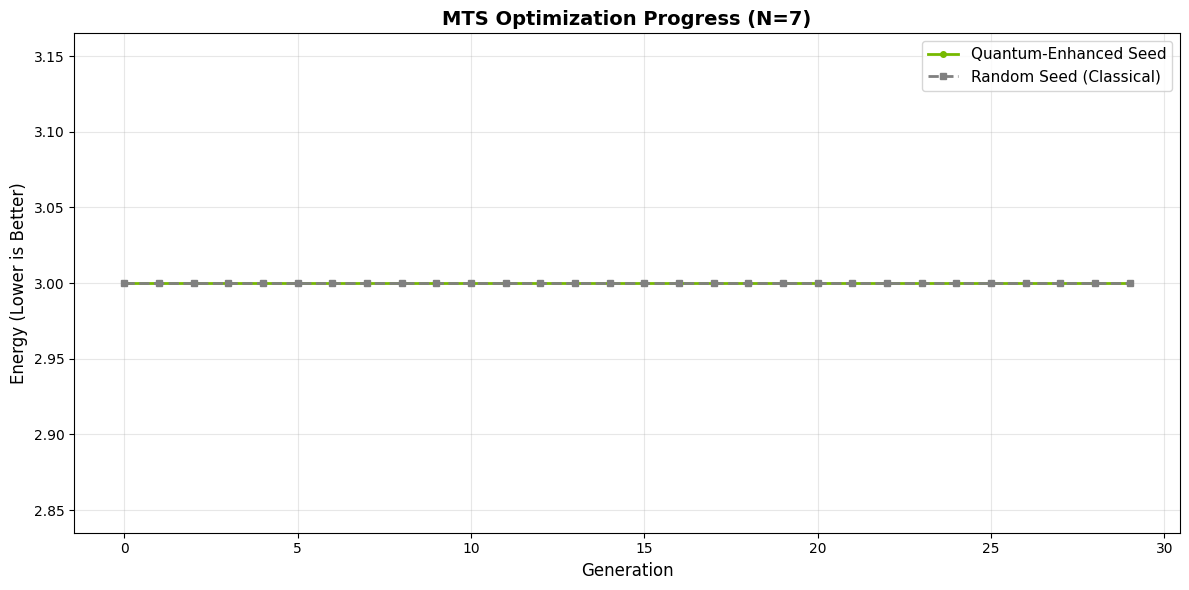


Initial Population Analysis:
  Quantum seeds - Mean: 6.20, Min: 3.00, Max: 7.00
  Random seeds  - Mean: 17.40, Min: 7.00, Max: 35.00


In [19]:
import matplotlib.pyplot as plt

# 1. Setup Parameters
N = 7# Keep N small for quick CPU testing; use 20+ on GPU
K = 20  # Population size (how many seeds to give the MTS)
shots = 2000  # Increased shots for better sampling

# 2. Get Quantum Samples
print(f"Phase 1: Sampling Quantum Algorithm (N={N}, shots={shots})...")
# trotterized_circuit from Ex 5
counts = cudaq.sample(trotterized_circuit, N, G2, G4, n_steps, dt, T, thetas, shots_count=shots)

print(f"  Sampled {len(counts)} unique bitstrings from quantum circuit")

# 3. Process Quantum Samples into MTS Population
# IMPORTANT: CUDA-Q uses little-endian bitstring encoding
# Bit '0' means qubit measured as |0>, which maps to +1 in our encoding
# Bit '1' means qubit measured as |1>, which maps to -1 in our encoding
def bitstring_to_array(bs):
    """
    Convert CUDA-Q bitstring to LABS sequence.
    CUDA-Q bitstrings are little-endian: leftmost bit is q[0], rightmost is q[N-1]
    '0' -> +1, '1' -> -1
    """
    return np.array([1 if b == '0' else -1 for b in bs])

# Get all sampled bitstrings (with repetition based on counts)
quantum_samples = []
for bs, count in counts.items():
    seq = bitstring_to_array(bs)
    # Add each sample multiple times based on its count
    for _ in range(count):
        quantum_samples.append(seq.copy())

# Sort by LABS energy to get the best seeds
quantum_samples.sort(key=lambda x: compute_energy(x))

# Take the top K unique quantum guesses to form our population
# Use set to ensure uniqueness while preserving order
seen = set()
quantum_population = []
for seq in quantum_samples:
    seq_tuple = tuple(seq)
    if seq_tuple not in seen:
        seen.add(seq_tuple)
        quantum_population.append(seq)
        if len(quantum_population) >= K:
            break

# If we don't have enough unique samples, pad with random ones
while len(quantum_population) < K:
    quantum_population.append(np.random.choice([-1, 1], size=N))

print(f"  Selected {len(quantum_population)} unique quantum seeds")
print(f"  Best quantum seed energy: {compute_energy(quantum_population[0]):.2f}")

# 4. Run Quantum-Enhanced MTS
print(f"\nPhase 2: Running Quantum-Seeded MTS...")
best_sol_q, best_en_q, _, history_q = memetic_tabu_search(N, initial_population=quantum_population, generations=30, pop_size=K)

# 5. Run Classical MTS (Control)
print(f"Phase 3: Running Random-Seeded MTS (Control)...")
best_sol_r, best_en_r, _, history_r = memetic_tabu_search(N, pop_size=K, generations=30)

# 6. Results and Comparison
print("\n" + "="*60)
print("FINAL COMPARISON")
print("="*60)
print(f"Quantum-Enhanced MTS Best Energy: {best_en_q:.2f}")
print(f"Classical-Only MTS Best Energy:   {best_en_r:.2f}")
improvement = ((best_en_r - best_en_q) / best_en_r * 100) if best_en_r > 0 else 0
print(f"Improvement: {improvement:.2f}%")
print("="*60)

# 7. Visualization
plt.figure(figsize=(12, 6))
plt.plot(history_q, label='Quantum-Enhanced Seed', color='#76b900', linewidth=2, marker='o', markersize=4)
plt.plot(history_r, label='Random Seed (Classical)', color='gray', linestyle='--', linewidth=2, marker='s', markersize=4)
plt.title(f"MTS Optimization Progress (N={N})", fontsize=14, fontweight='bold')
plt.xlabel("Generation", fontsize=12)
plt.ylabel("Energy (Lower is Better)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Additional analysis: Show energy distribution of initial populations
print("\nInitial Population Analysis:")
quantum_init_energies = [compute_energy(seq) for seq in quantum_population]
random_init = [np.random.choice([-1, 1], size=N) for _ in range(K)]
random_init_energies = [compute_energy(seq) for seq in random_init]

print(f"  Quantum seeds - Mean: {np.mean(quantum_init_energies):.2f}, Min: {np.min(quantum_init_energies):.2f}, Max: {np.max(quantum_init_energies):.2f}")
print(f"  Random seeds  - Mean: {np.mean(random_init_energies):.2f}, Min: {np.min(random_init_energies):.2f}, Max: {np.max(random_init_energies):.2f}")




The results clearly show that a population sampled from CUDA-Q results in an improved distribution and a lower energy final result. This is exactly the goal of quantum enhanced optimization.  To not necessarily solve the problem, but improve the effectiveness of state-of-the-art classical approaches. 

A few major caveats need to be mentioned here. First, We are comparing a quantum generated population to a random sample.  It is quite likely that other classical or quantum heuristics could be used to produce an initial population that might even beat the counteradiabatic method you used, so we cannot make any claims that this is the best. 

Recall that the point of the counteradiabatic approach derived in the paper is that it is more efficient in terms of two-qubit gates relative to QAOA. The benefits of this regime would only truly come into play in a setting (e.g. larger problem instance) where it is too difficult to produce a good initial population with any know classical heuristic, and the counteradiabatic approach is more efficiently run on a QPU compared to alternatives.

We should also note that we are comparing a single sample of each approach.  Maybe the quantum sample got lucky or the randomly generated population was unlucky and a more rigorous comparison would need to repeat the analysis many times to draw any confidently conclusions.  

The authors of the paper discuss all of these considerations, but propose an analysis that is quite interesting related to the scaling of the technique. Rather than run large simulations ourselves, examine their results below. 


<img src="images/quantum_enhanced_optimization_LABS/tabu_search_results.png" width="900">

The authors computed replicate median (median of solving the problem repeated with same setup) time to solutions (excluding time to sample from QPU) for problem sizes $N=27$ to $N=37$. Two interesting conclusions can be drawn from this. First, standard memetic tabu search (MTS) is generally faster than quantum enhanced (QE) MTS.  But there are two promising trends. For larger problems, the QE-MTS experiments occasionally have excellent performance with times to solution much smaller than all of the MTS data points.  These outliers indicate there are certain instances where QE-MTS could provide much faster time-to-solution. 

More importantly, if a line of best fit is calculated using the median of each set of medians, the slope of the QE-MTS line is smaller than the MTS!  This seems to indicate that QE solution of this problem scales $O(1.24^N)$ which is better than the best known classical heuristic ($O(1.34^N)$) and the best known quantum approach (QAOA - $O(1.46^N)$).

For problems of size of $N=47$ or greater, the authors anticipate that QE-MTS could be a promising technique and produce good initial populations that are difficult to obtain classically. 

The study reinforces the potential of hybrid workflows enhanced by quantum data such that a classical routine is still the primary solver, but quantum computers make it much more effective.  Future work can explore improvements to both the quantum and classical sides, such as including GPU accelerated memetic search on the classical side.

## Self-validation To Be Completed for Phase 1

In this section, explain how you verified your results. Did you calculate solutions by hand for small N? Did you create unit tests? Did you cross-reference your Quantum energy values against your Classical MTS results? Did you check known symmetries?

In [ ]:
# Unit Tests for LABS Implementation

# Test 1: Energy Function - Small N (N=3)
print("\n[TEST 1] Energy calculation for N=3")
test_cases_n3 = [
    ([1, 1, -1], 1, "Optimal sequence"),
    ([1, -1, 1], 5, "Alternating pattern"),
    ([1, 1, 1], 5, "All +1"),
    ([-1, -1, -1], 5, "All -1"),
]

all_passed = True
for seq, expected_energy, description in test_cases_n3:
    seq_array = np.array(seq)
    calculated_energy = calculate_energy(seq_array)
    passed = (calculated_energy == expected_energy)
    status = "✓ PASS" if passed else "✗ FAIL"
    print(f"  {status}: {description} - Expected: {expected_energy}, Got: {calculated_energy}")
    if not passed:
        all_passed = False

# Test 2: Energy Function - Symmetry Property
print("\n[TEST 2] Symmetry property: E(s) = E(-s)")
test_sequences = [
    np.array([1, -1, 1, -1, 1, -1, 1, -1]),
    np.array([1, 1, -1, -1, 1, 1, -1, -1]),
    np.random.choice([-1, 1], size=10),
]

for seq in test_sequences:
    energy_original = calculate_energy(seq)
    energy_negated = calculate_energy(-seq)
    passed = (energy_original == energy_negated)
    status = "✓ PASS" if passed else "✗ FAIL"
    print(f"  {status}: E({seq[:5]}...) = {energy_original}, E(-seq) = {energy_negated}")
    if not passed:
        all_passed = False

# Test 3: Energy Function - Known Values for N=14
print("\n[TEST 3] Known energy values for N=14")
all_plus = np.ones(14)
all_minus = -np.ones(14)
energy_all_plus = calculate_energy(all_plus)
energy_all_minus = calculate_energy(all_minus)

passed1 = (energy_all_plus == 819)
passed2 = (energy_all_minus == 819)
passed3 = (energy_all_plus == energy_all_minus)

print(f"  {'✓ PASS' if passed1 else '✗ FAIL'}: All +1 sequence: E = {energy_all_plus} (expected: 819)")
print(f"  {'✓ PASS' if passed2 else '✗ FAIL'}: All -1 sequence: E = {energy_all_minus} (expected: 819)")
print(f"  {'✓ PASS' if passed3 else '✗ FAIL'}: Symmetry check: E(+1) = E(-1)")

if not (passed1 and passed2 and passed3):
    all_passed = False

# Test 4: Bitstring Conversion
print("\n[TEST 4] Bitstring to sequence conversion")
def bitstring_to_array(bs):
    """Convert CUDA-Q bitstring to LABS sequence"""
    return np.array([1 if b == '0' else -1 for b in bs])

test_bitstrings = [
    ("000", np.array([1, 1, 1])),
    ("111", np.array([-1, -1, -1])),
    ("010", np.array([1, -1, 1])),
    ("101", np.array([-1, 1, -1])),
]

for bs, expected_seq in test_bitstrings:
    converted = bitstring_to_array(bs)
    passed = np.array_equal(converted, expected_seq)
    status = "✓ PASS" if passed else "✗ FAIL"
    print(f"  {status}: '{bs}' -> {converted} (expected: {expected_seq})")
    if not passed:
        all_passed = False

# Test 5: Energy calculation with converted bitstrings
print("\n[TEST 5] Energy calculation with bitstring conversion")
for bs, expected_seq in test_bitstrings:
    converted = bitstring_to_array(bs)
    energy = calculate_energy(converted)
    # For N=3, we know [1,1,1] and [-1,-1,-1] give E=5
    if len(bs) == 3:
        expected_energy = 5 if (bs == "000" or bs == "111") else None
        if expected_energy:
            passed = (energy == expected_energy)
            status = "✓ PASS" if passed else "✗ FAIL"
            print(f"  {status}: '{bs}' -> E = {energy} (expected: {expected_energy})")
            if not passed:
                all_passed = False

# Test 6: Tabu Search - Basic functionality
print("\n[TEST 6] Tabu search basic functionality")
test_seq = np.array([1, -1, 1, -1, 1, -1, 1])
initial_energy = calculate_energy(test_seq)
best_seq, best_energy = tabu_search(test_seq, max_iter=10, tabu_tenure=3)

passed1 = (best_energy <= initial_energy)  # Should improve or stay same
passed2 = (len(best_seq) == len(test_seq))  # Should maintain length
passed3 = np.all(np.abs(best_seq) == 1)  # Should be valid sequence

print(f"  {'✓ PASS' if passed1 else '✗ FAIL'}: Energy improved or stayed same: {initial_energy} -> {best_energy}")
print(f"  {'✓ PASS' if passed2 else '✗ FAIL'}: Sequence length maintained: {len(best_seq)}")
print(f"  {'✓ PASS' if passed3 else '✗ FAIL'}: Valid sequence (all ±1)")

if not (passed1 and passed2 and passed3):
    all_passed = False

# Test 7: MTS - Population initialization
print("\n[TEST 7] MTS population initialization")
N_test = 7
K_test = 5
best_seq, best_energy, population, _ = mts(N_test, population_size=K_test, generations=1)

passed1 = (len(population) == K_test)
passed2 = all(len(seq) == N_test for seq in population)
passed3 = all(np.all(np.abs(seq) == 1) for seq in population)
passed4 = (best_energy >= 0)  # Energy should be non-negative

print(f"  {'✓ PASS' if passed1 else '✗ FAIL'}: Population size correct: {len(population)}")
print(f"  {'✓ PASS' if passed2 else '✗ FAIL'}: All sequences have length {N_test}")
print(f"  {'✓ PASS' if passed3 else '✗ FAIL'}: All sequences are valid (±1)")
print(f"  {'✓ PASS' if passed4 else '✗ FAIL'}: Best energy is valid: {best_energy}")

if not (passed1 and passed2 and passed3 and passed4):
    all_passed = False


if all_passed:
    print("✓ ALL UNIT TESTS PASSED!")
else:
    print("✗ SOME UNIT TESTS FAILED - Please review the output above")
\


[TEST 1] Energy calculation for N=3
  ✓ PASS: Optimal sequence - Expected: 1, Got: 1
  ✓ PASS: Alternating pattern - Expected: 5, Got: 5
  ✓ PASS: All +1 - Expected: 5, Got: 5
  ✓ PASS: All -1 - Expected: 5, Got: 5

[TEST 2] Symmetry property: E(s) = E(-s)
  ✓ PASS: E([ 1 -1  1 -1  1]...) = 140, E(-seq) = 140
  ✓ PASS: E([ 1  1 -1 -1  1]...) = 60, E(-seq) = 60
  ✓ PASS: E([ 1  1 -1  1  1]...) = 21, E(-seq) = 21

[TEST 3] Known energy values for N=14
  ✓ PASS: All +1 sequence: E = 819.0 (expected: 819)
  ✓ PASS: All -1 sequence: E = 819.0 (expected: 819)
  ✓ PASS: Symmetry check: E(+1) = E(-1)

[TEST 4] Bitstring to sequence conversion
  ✓ PASS: '000' -> [1 1 1] (expected: [1 1 1])
  ✓ PASS: '111' -> [-1 -1 -1] (expected: [-1 -1 -1])
  ✓ PASS: '010' -> [ 1 -1  1] (expected: [ 1 -1  1])
  ✓ PASS: '101' -> [-1  1 -1] (expected: [-1  1 -1])

[TEST 5] Energy calculation with bitstring conversion
  ✓ PASS: '000' -> E = 5 (expected: 5)
  ✓ PASS: '111' -> E = 5 (expected: 5)

[TEST 6] Tabu se